# Skin cancer detection using tensorflow: comparison of different approaches

Here is the skin cancer detection example. Two datasets were used for it:

small dataset  https://www.kaggle.com/datasets/rajivaiml/isic-skin-cancer-dataset, which contains 2239 files belonging to 9 classes for training and 118 files for testing.

bigger dataset https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset/data, I used union of those datasets. Tryed to avoid using the same images (datasets overlapped).
The total dataset is orginized as  4658 files belonging to 7 classes for training and 979 files belonging to 7 classes. This proportion can be easily changes with file 'Create_folder_structure.ipynb'

| Dx                    | Train | Test |
|-----------------------|-------|------|
| melanoma              | 1328  | 239  |
| nevus                 | 1317  | 256  |
| basal cell carcinoma  | 492   | 116  |
| actinic keratosis     | 311   | 77   |
| vascular lesion       | 140   | 30   |
| seborrheic keratosis  | 955   | 223  |
| dermatofibroma        | 114   | 38   |I didn’t fully balanced the dataset, because some of classes consists of 150-170 images only, which is not enough for building the neural network.  114	38


I didn’t fully balanced the dataset, because some of classes consists of 150-170 images only, which is not enough for building the neural network.  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
import pandas as pd
import os
import cv2

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile(data_dir+'skin_cancer.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [ ]:
data_dir = os.path.join(data_dir, 'skin_cancer')

In [ ]:
img_height = 128
img_width = 128
batch_size = 64

In [ ]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

In [ ]:
dir=fast_scandir(os.path.join(data_dir, 'Train'))

for d2 in dir:
    label = str(d2).replace( os.path.join(data_dir, 'Train')+'/','')
    n_d2 = len(os.listdir(d2))
    print(label, ': ', n_d2)

melanoma :  1328
nevus :  1317
basal cell carcinoma :  492
actinic keratosis :  311
vascular lesion :  140
seborrheic keratosis :  956
dermatofibroma :  114


In [ ]:
dir=fast_scandir(os.path.join(data_dir, 'Test'))

for d2 in dir:
    label = str(d2).replace( os.path.join(data_dir, 'Test')+'/','')
    n_d2 = len(os.listdir(d2))
    print(label, ': ', n_d2)

melanoma :  239
nevus :  256
basal cell carcinoma :  116
actinic keratosis :  77
vascular lesion :  30
seborrheic keratosis :  223
dermatofibroma :  38


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(data_dir, 'Train'),
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 4658 files belonging to 7 classes.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 7)


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(data_dir, 'Test'),
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 979 files belonging to 7 classes.


In [ ]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'seborrheic keratosis',
 'vascular lesion']

In [ ]:
class_names = train_ds.class_names
print(class_names)
num_outputs = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'seborrheic keratosis', 'vascular lesion']


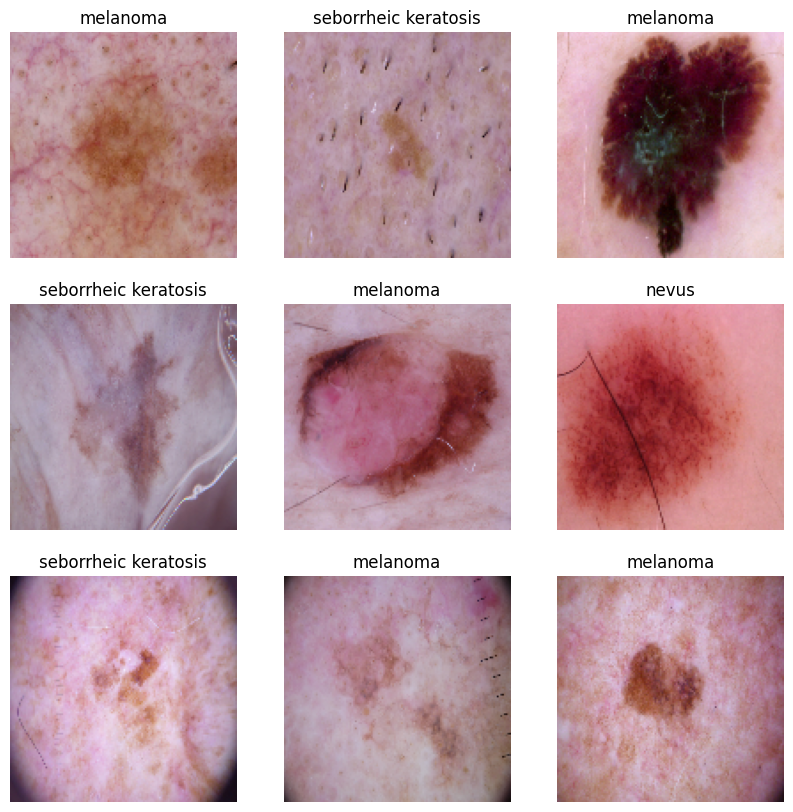

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = tf.argmax(labels[i].numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Approach 1: the simplest model - starting point

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(num_outputs, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs = 50, batch_size = 32, verbose = 1 , validation_data = test_ds)

Best validation accuracy: 0.64

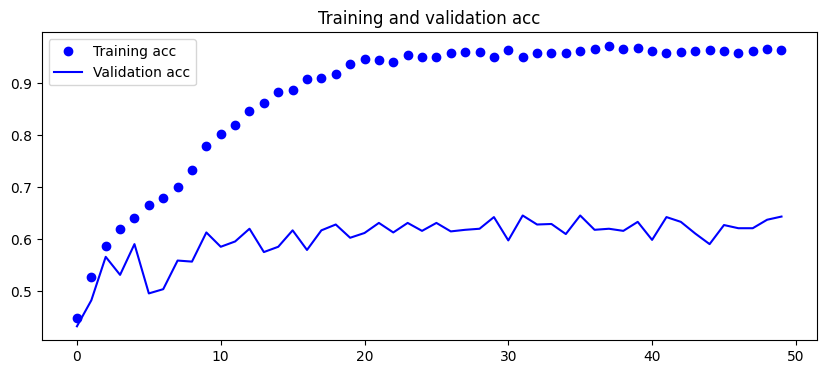

<Figure size 640x480 with 0 Axes>

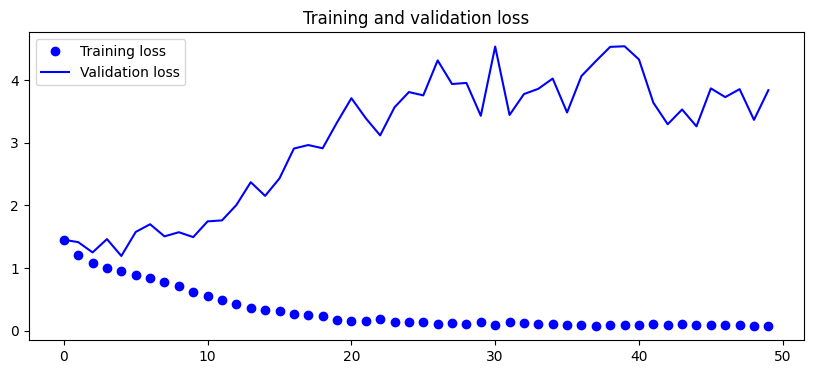

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In this problem the chance level is 1/7 = 14%. So the best validation accuracy is 0.52 - that is not bad.

In [ ]:
predictions = tf.argmax( predictions, axis=1)
labels = tf.argmax( labels, axis=1)

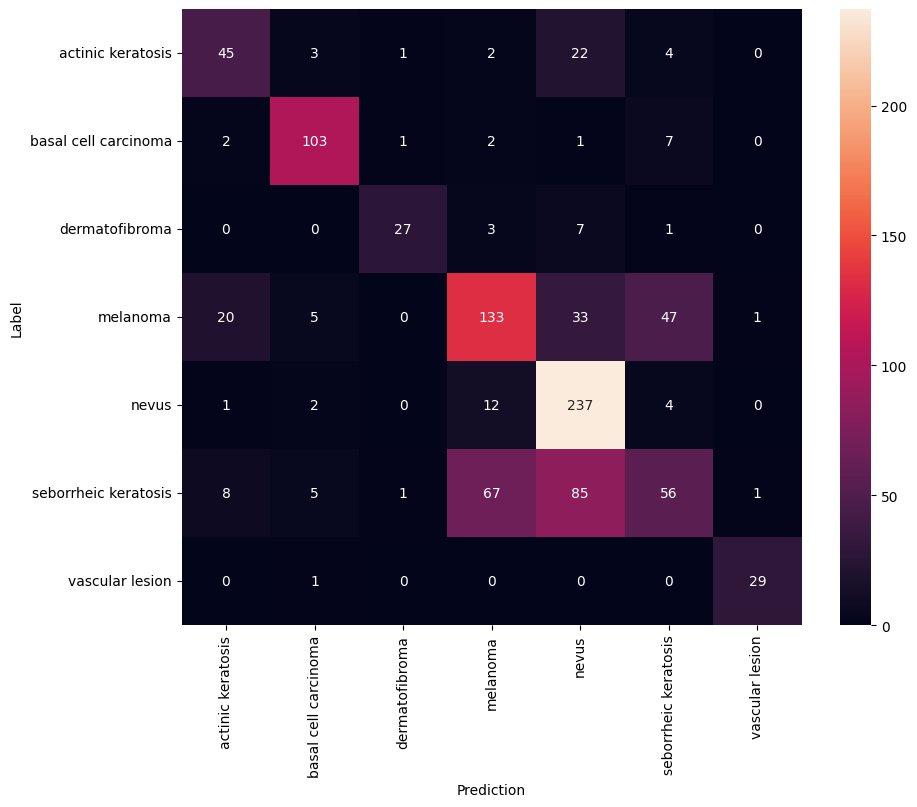

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.5844155844155844,
 'basal cell carcinoma': 0.8879310344827587,
 'dermatofibroma': 0.7105263157894737,
 'melanoma': 0.5564853556485355,
 'nevus': 0.92578125,
 'seborrheic keratosis': 0.25112107623318386,
 'vascular lesion': 0.9666666666666667}

# Approach 2: adding more layers to detect features

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(num_outputs, activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs = 50, batch_size = 32, verbose = 1 , validation_data = test_ds)

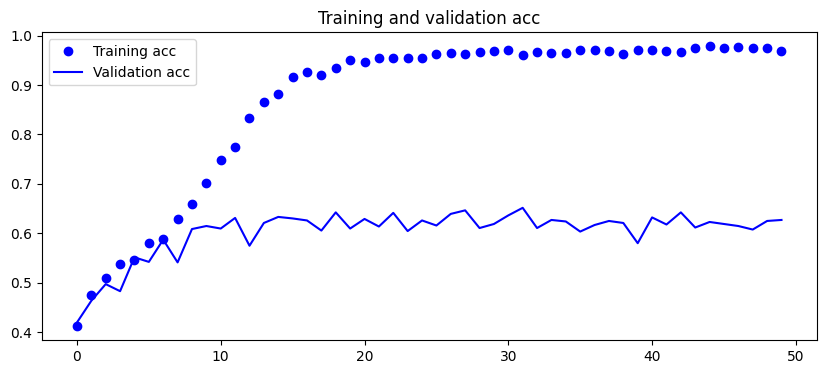

<Figure size 640x480 with 0 Axes>

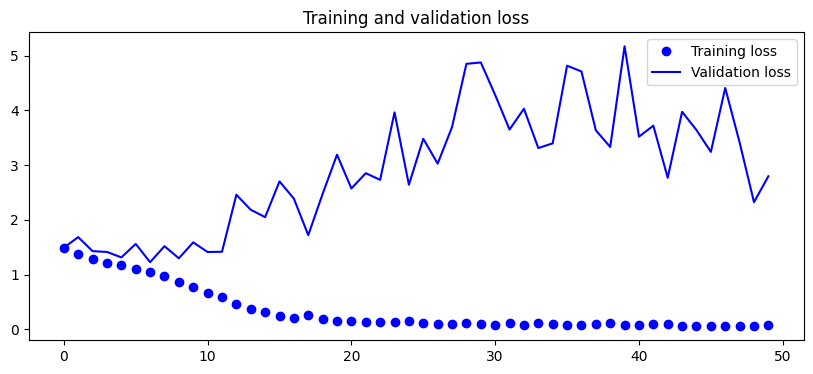

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
images = []
labels = []
for image, label in test_ds.take(-1):
  images.extend(image)
  labels.extend(label)
images = np.array(images)
labels = np.array(labels)

predictions = model.predict(images)

31/31 [==============================] - 0s 12ms/step


In [ ]:
predictions = tf.argmax( predictions, axis=1)
labels = tf.argmax( labels, axis=1)

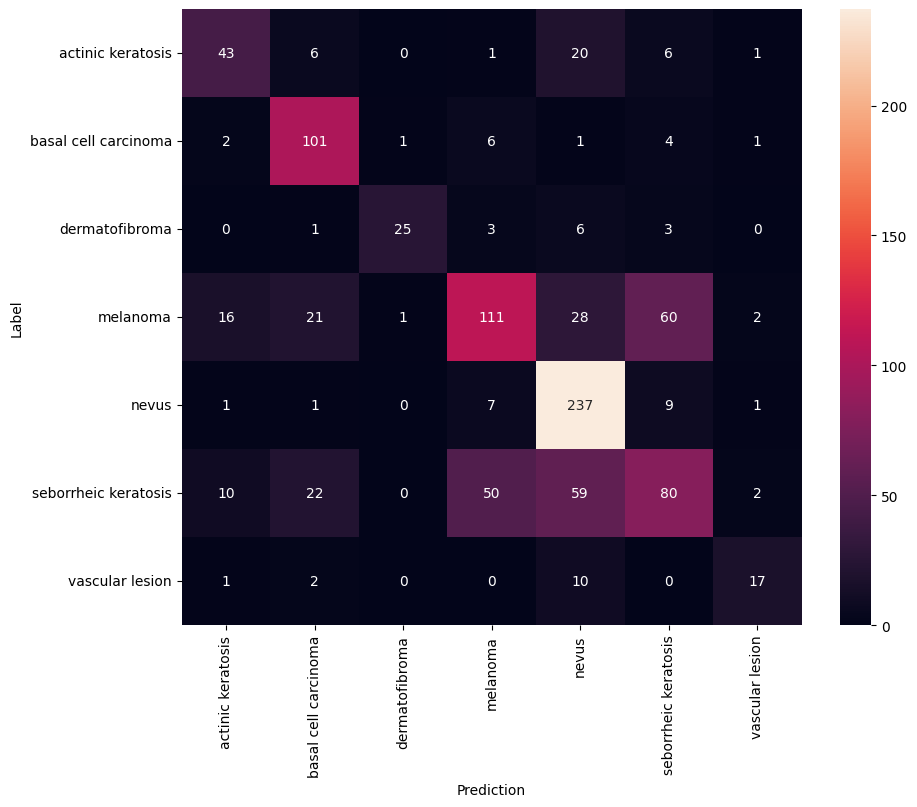

In [ ]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.5584415584415584,
 'basal cell carcinoma': 0.8706896551724138,
 'dermatofibroma': 0.6578947368421053,
 'melanoma': 0.46443514644351463,
 'nevus': 0.92578125,
 'seborrheic keratosis': 0.35874439461883406,
 'vascular lesion': 0.5666666666666667}

## Adding dropout layers

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(num_outputs, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 58, 64)        36928     
                                                      

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1 , validation_data = test_ds)

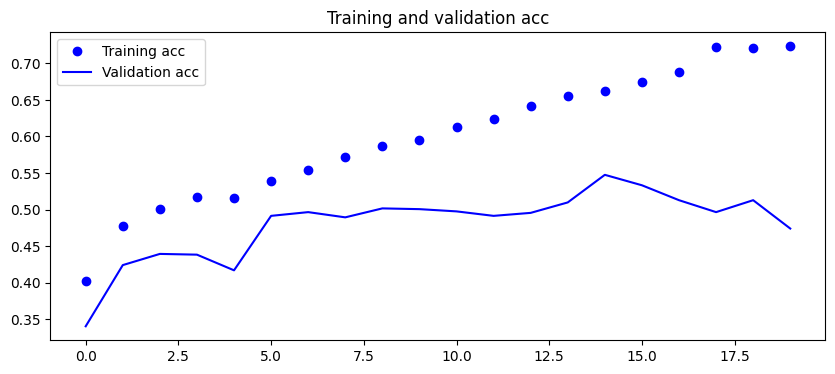

<Figure size 640x480 with 0 Axes>

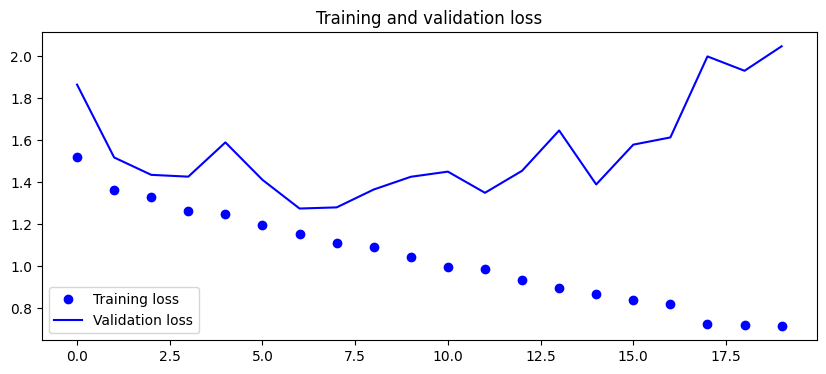

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predictions = tf.argmax( predictions, axis=1)
labels = tf.argmax( labels, axis=1)

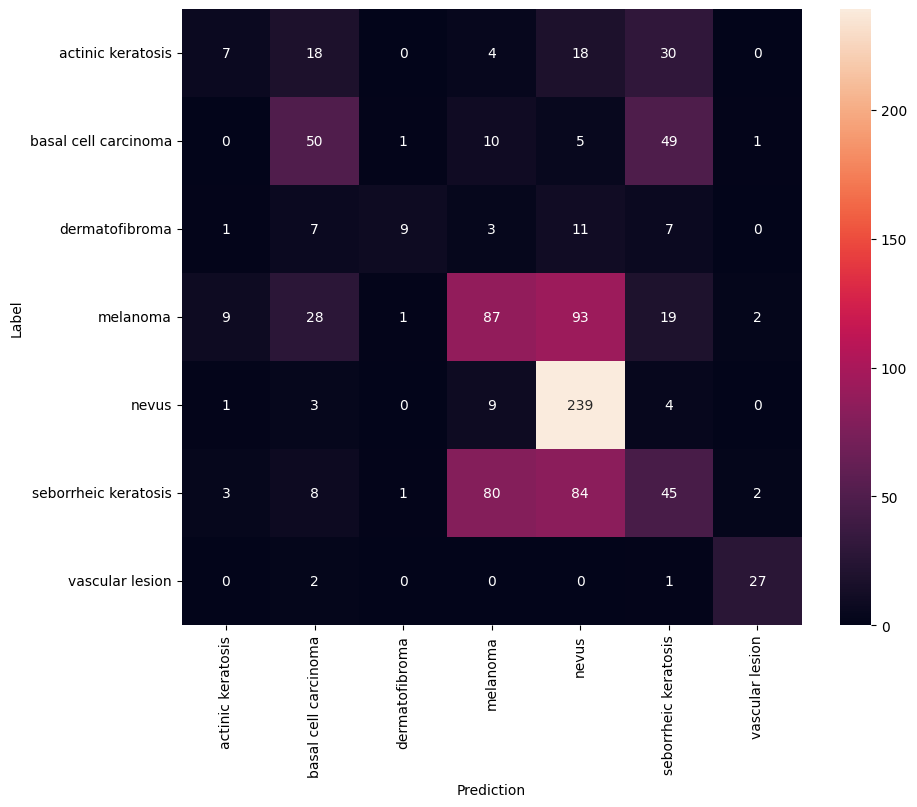

In [ ]:

confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.09090909090909091,
 'basal cell carcinoma': 0.43103448275862066,
 'dermatofibroma': 0.23684210526315788,
 'melanoma': 0.36401673640167365,
 'nevus': 0.93359375,
 'seborrheic keratosis': 0.20179372197309417,
 'vascular lesion': 0.9}

# Approach 3: datagen

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=45,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        data_dir+'/Train',
        target_size=(img_height, img_width),
        batch_size=64,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        data_dir+'/Test',
        target_size=(img_height, img_width),
        batch_size=64,
        shuffle='False',
        class_mode='categorical')

Found 4658 images belonging to 7 classes.
Found 979 images belonging to 7 classes.


In [ ]:
class_dict = train_generator.class_indices
class_dict

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'seborrheic keratosis': 5,
 'vascular lesion': 6}

In [ ]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)
num_outputs = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'seborrheic keratosis', 'vascular lesion']


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(num_outputs, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 50176)            

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs = 50, verbose = 1
                    , validation_data=validation_generator)

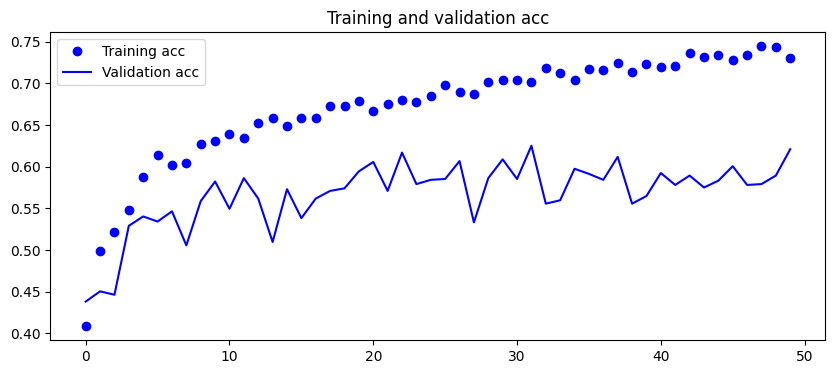

<Figure size 640x480 with 0 Axes>

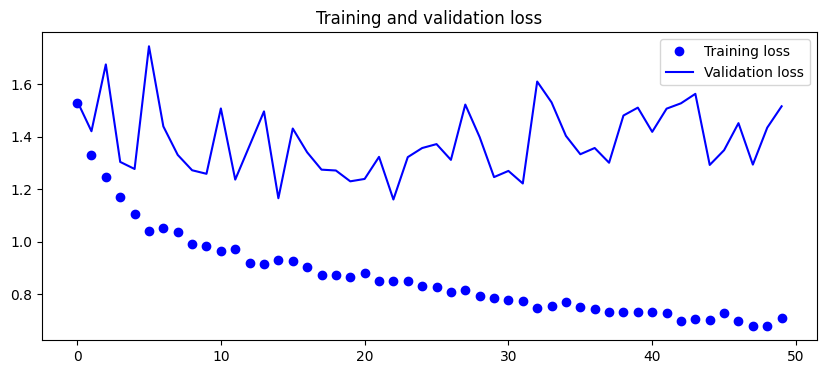

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save(data_dir+'/cnn1_datagen.keras')

In [ ]:
labels = []
predictions = []
for i in range(979//64):
    img_batch, label_batch = validation_generator[i]
    pred = np.argmax(model.predict(img_batch),-1)
    lb = np.argmax(label_batch,-1)
    for j in range(64):
        labels.append(lb[j])
        predictions.append(pred[j])

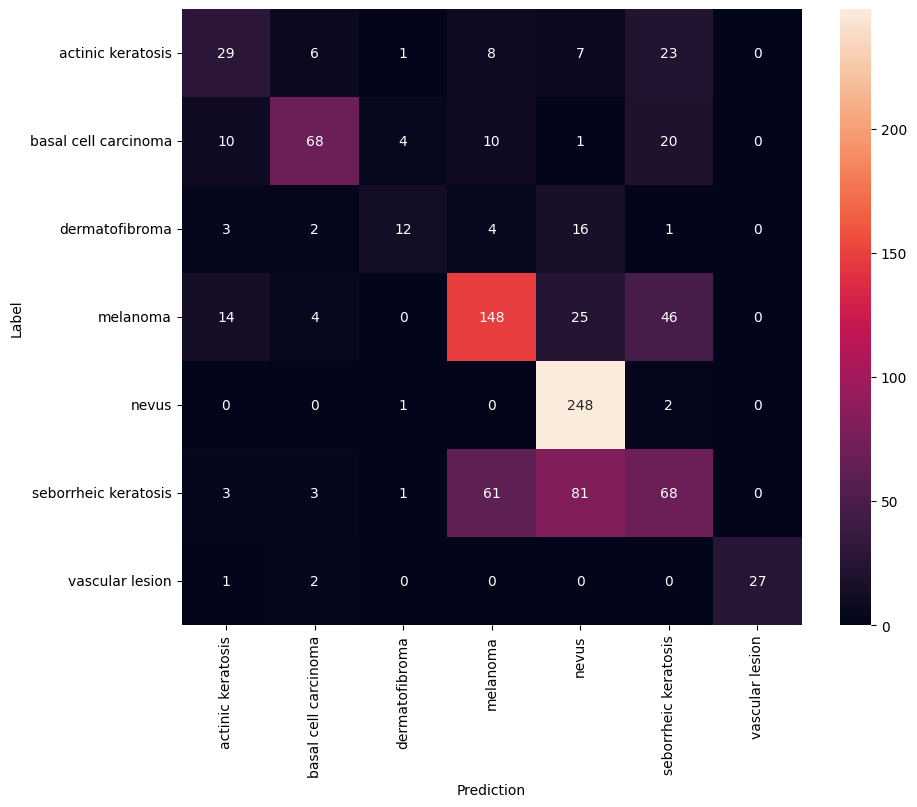

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.3918918918918919,
 'basal cell carcinoma': 0.6017699115044248,
 'dermatofibroma': 0.3157894736842105,
 'melanoma': 0.6244725738396625,
 'nevus': 0.9880478087649402,
 'seborrheic keratosis': 0.31336405529953915,
 'vascular lesion': 0.9}

# Xception model

In [ ]:
xcept_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    pooling='max',
    input_shape=(128, 128, 3))

#xcept_model.summary()

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential()
model.add(xcept_model)
model.add(keras.layers.Dense(num_outputs, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 20875823 (79.63 MB)
Trainable params: 20821295 (79.43 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
model.trainable = True
set_trainable = False
for layer in xcept_model.layers:
    if layer.name == 'block14_sepconv2' or layer.name == 'block14_sepconv1' or layer.name == 'block13_sepconv2' or layer.name == 'block13_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### No Datagen

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs = 50, batch_size = 16, verbose = 1 , validation_data = test_ds)

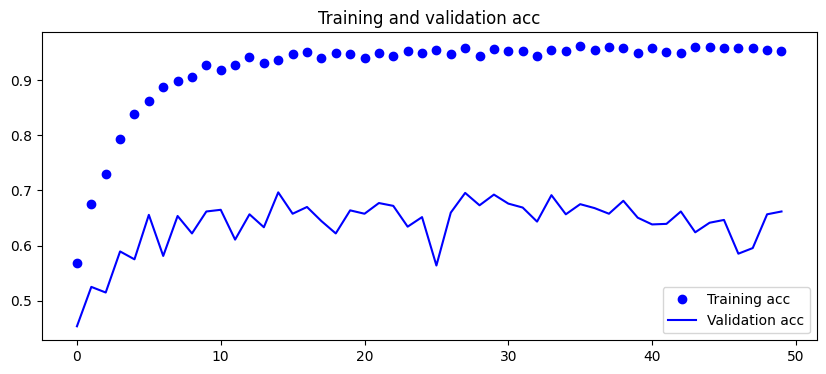

<Figure size 640x480 with 0 Axes>

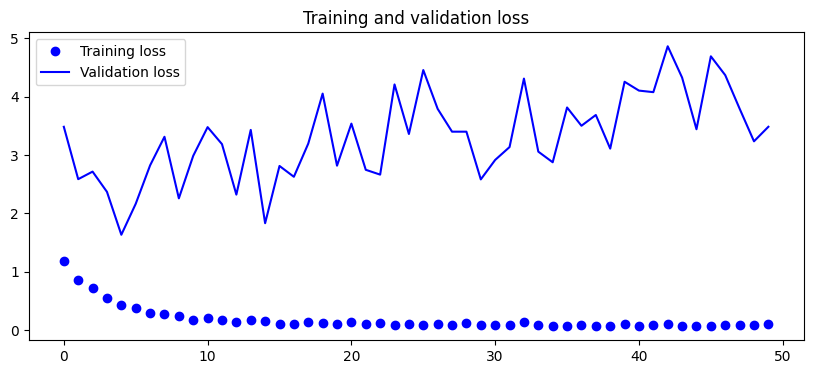

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
images = []
labels = []
for image, label in test_ds.take(-1):
  images.extend(image)
  labels.extend(label)
images = np.array(images)
labels = np.array(labels)

predictions = model.predict(images)

31/31 [==============================] - 2s 42ms/step


In [ ]:
predictions = tf.argmax( predictions, axis=1)
labels = tf.argmax( labels, axis=1)

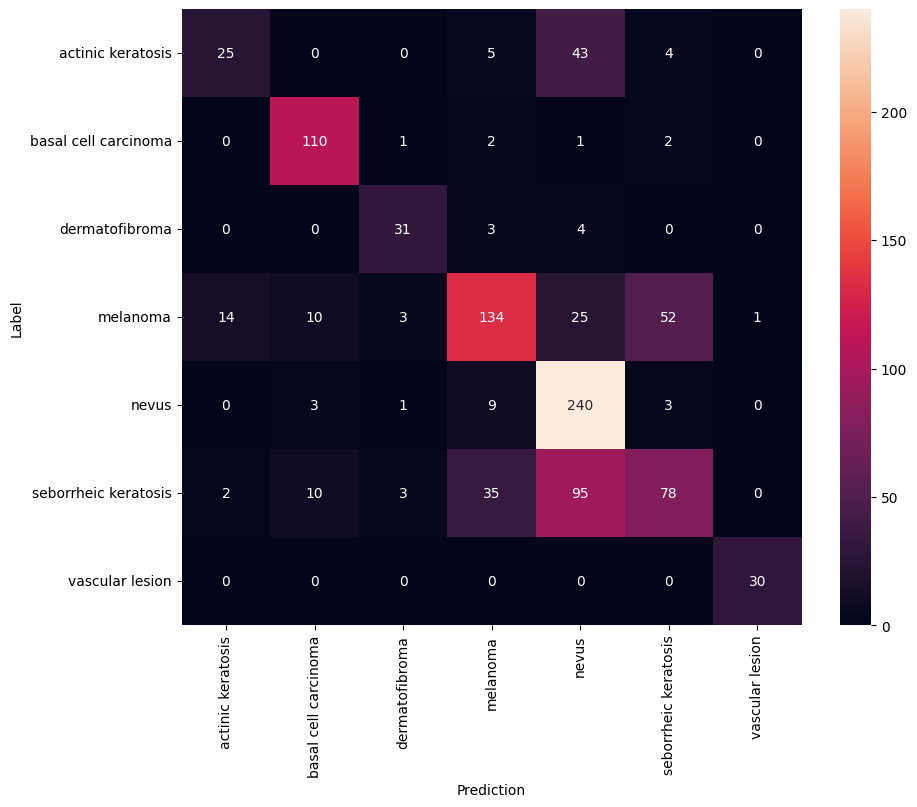

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.3246753246753247,
 'basal cell carcinoma': 0.9482758620689655,
 'dermatofibroma': 0.8157894736842105,
 'melanoma': 0.5606694560669456,
 'nevus': 0.9375,
 'seborrheic keratosis': 0.34977578475336324,
 'vascular lesion': 1.0}

### With datagen

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs = 50, verbose = 1#, callbacks = [callback]
                    , validation_data=validation_generator)

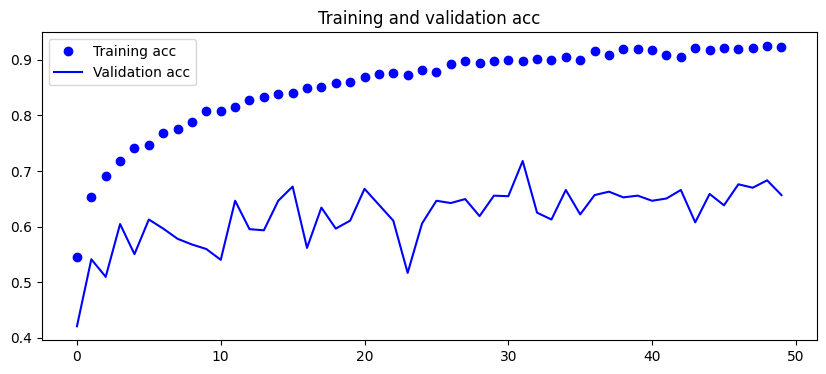

<Figure size 640x480 with 0 Axes>

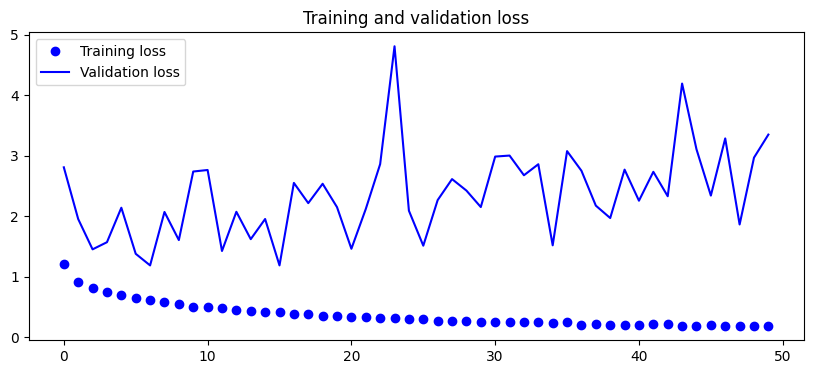

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save(data_dir+'/xcept_datagen.keras')

In [ ]:
labels = []
predictions = []
for i in range(979//64):
    img_batch, label_batch = validation_generator[i]
    pred = np.argmax(model.predict(img_batch),-1)
    lb = np.argmax(label_batch,-1)
    for j in range(64):
        labels.append(lb[j])
        predictions.append(pred[j])

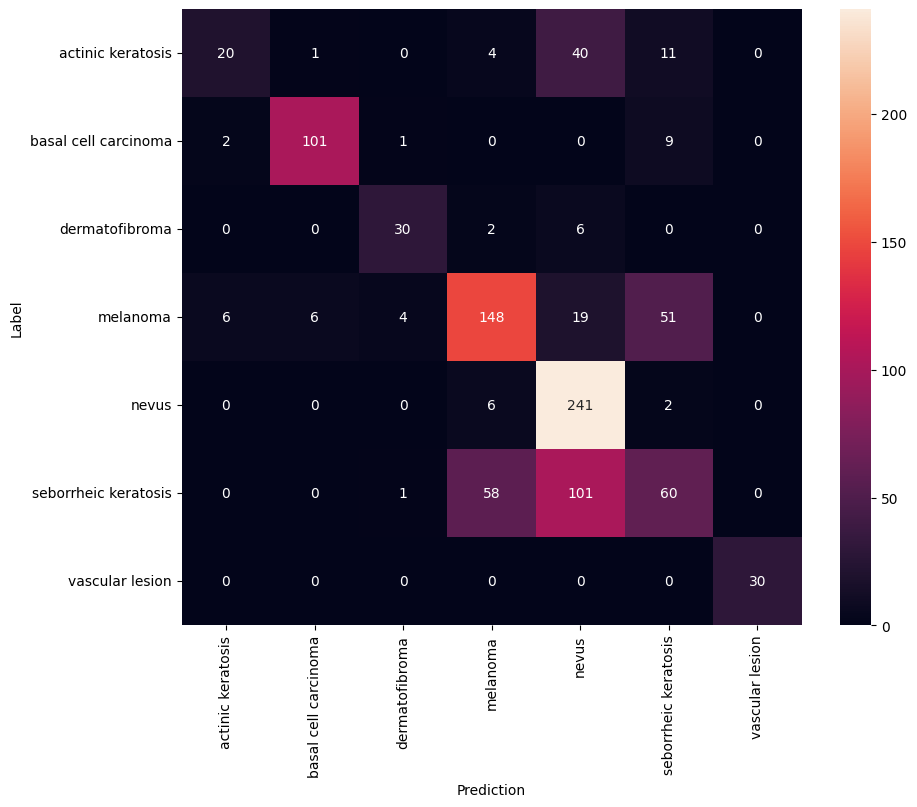

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.2631578947368421,
 'basal cell carcinoma': 0.8938053097345132,
 'dermatofibroma': 0.7894736842105263,
 'melanoma': 0.6324786324786325,
 'nevus': 0.9678714859437751,
 'seborrheic keratosis': 0.2727272727272727,
 'vascular lesion': 1.0}

# Resnet

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50( include_top=False, weights = 'imagenet',
                                                        pooling=None,
                                                        input_shape = (128,128,3)
                                                       )
#resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential()
model.add(resnet_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(num_outputs, activation='softmax'))

In [ ]:
model.trainable = True
set_trainable = False
for layer in resnet_model.layers:
    if layer.name == 'conv5_block3_3_conv' or layer.name == 'conv5_block3_2_conv' or layer.name == 'conv5_block3_1_conv' or layer.name == 'conv5_block2_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 64)                2097216   
                                                                 
 dense_8 (Dense)             (None, 7)                 455       
                                                                 
Total params: 25685383 (97.98 MB)
Trainable params: 7618055 (29.06 MB)
Non-trainable params: 18067328 (68.92 MB)
_________________________________________________________________


### No datagen

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs = 50, batch_size = 16, verbose = 1 , validation_data = test_ds)

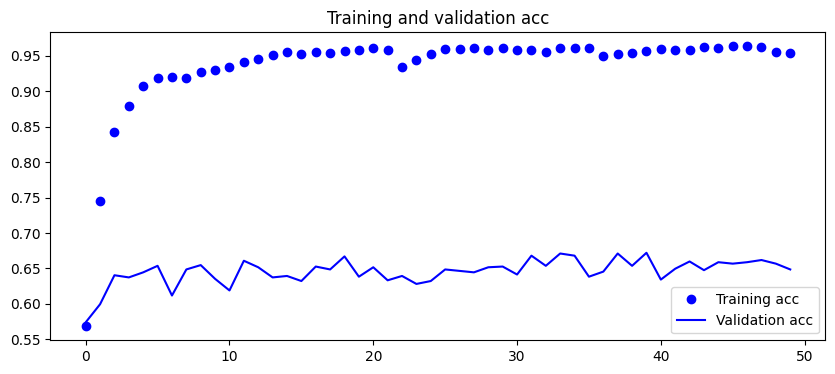

<Figure size 640x480 with 0 Axes>

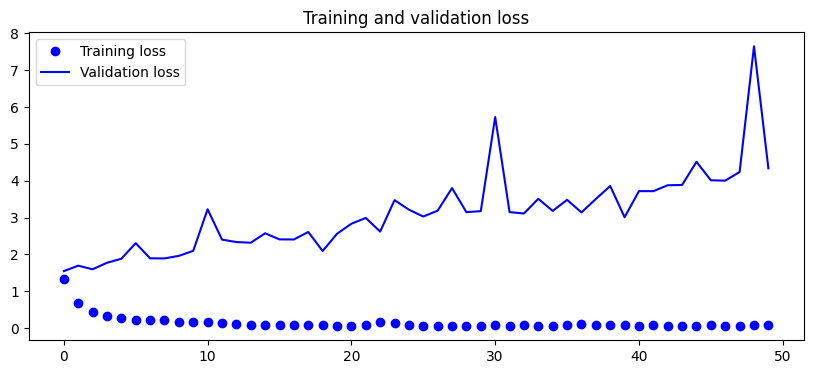

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
images = []
labels = []
for image, label in test_ds.take(-1):
  images.extend(image)
  labels.extend(label)
images = np.array(images)
labels = np.array(labels)

predictions = model.predict(images)

31/31 [==============================] - 2s 35ms/step


In [ ]:
predictions = tf.argmax( predictions, axis=1)
labels = tf.argmax( labels, axis=1)

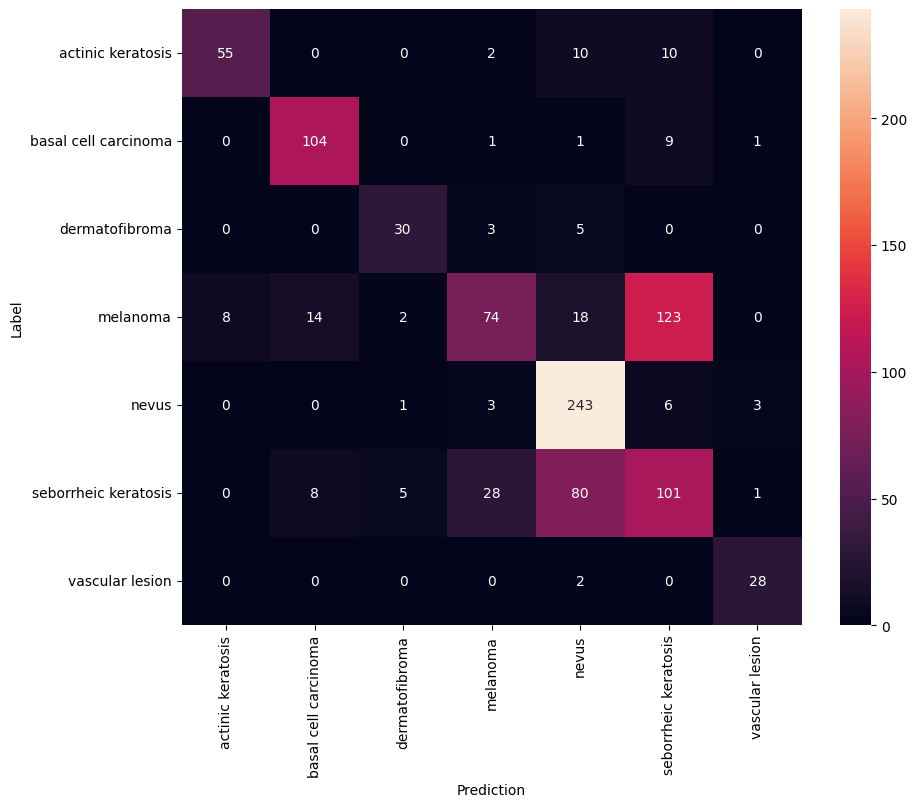

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.7142857142857143,
 'basal cell carcinoma': 0.896551724137931,
 'dermatofibroma': 0.7894736842105263,
 'melanoma': 0.30962343096234307,
 'nevus': 0.94921875,
 'seborrheic keratosis': 0.452914798206278,
 'vascular lesion': 0.9333333333333333}

### With Datagen

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs = 50, verbose = 1#, callbacks = [callback]
                    , validation_data=validation_generator)

In [ ]:
model.save(data_dir+'/resnet_datagen.keras')

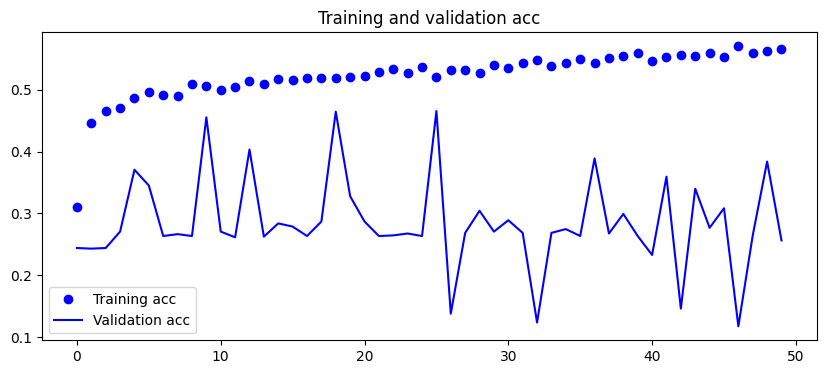

<Figure size 640x480 with 0 Axes>

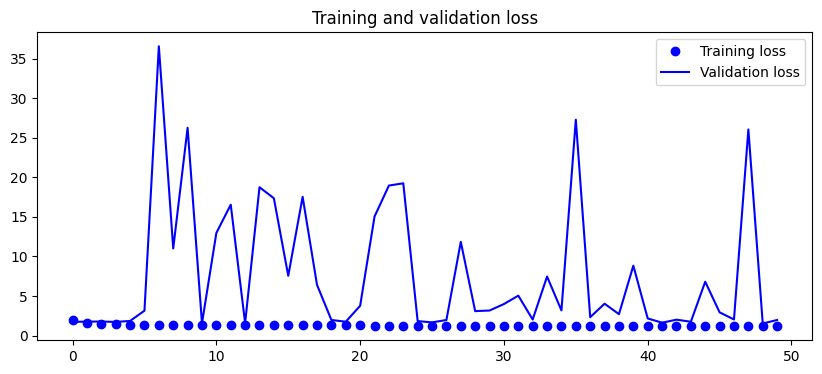

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
labels = []
predictions = []
for i in range(979//64):
    img_batch, label_batch = validation_generator[i]
    pred = np.argmax(model.predict(img_batch),-1)
    lb = np.argmax(label_batch,-1)
    for j in range(64):
        labels.append(lb[j])
        predictions.append(pred[j])

2/2 [==============================] - 0s 44ms/step


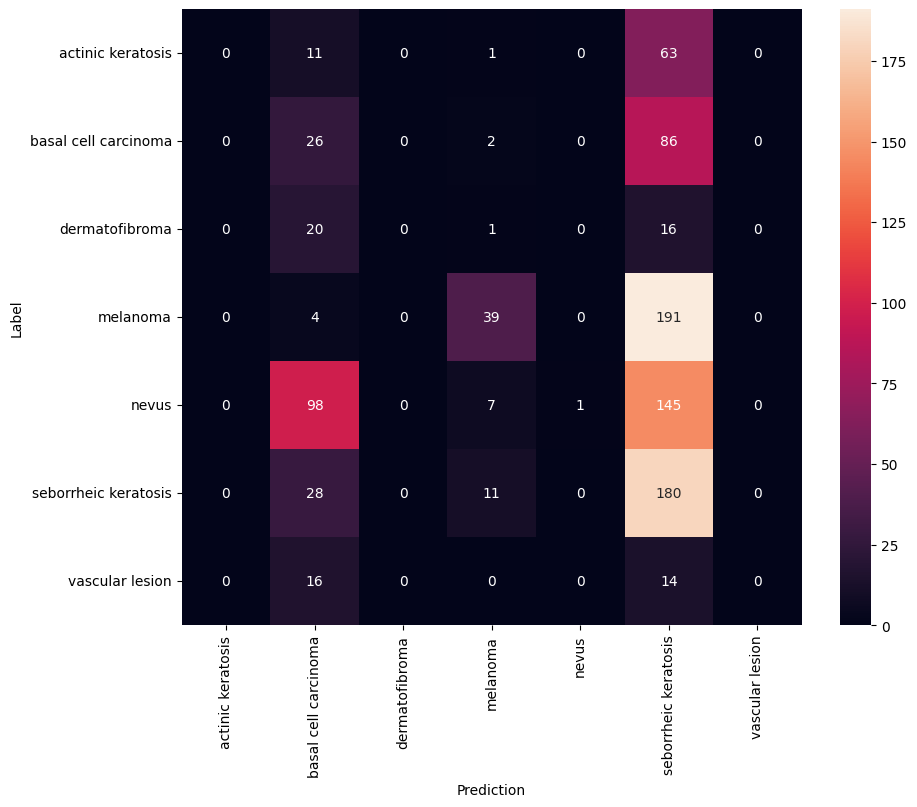

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class_acc = confusion_mtx.numpy().diagonal()/confusion_mtx.numpy().sum(axis=1)
class_acc_dict = dict(zip(class_names, class_acc))
class_acc_dict

{'actinic keratosis': 0.0,
 'basal cell carcinoma': 0.22807017543859648,
 'dermatofibroma': 0.0,
 'melanoma': 0.16666666666666666,
 'nevus': 0.00398406374501992,
 'seborrheic keratosis': 0.821917808219178,
 'vascular lesion': 0.0}

# Results comparison

The table below shows the result comparison for all the models.

| Diagnosis              | 3 conv layer | 6 conv layers | 3 conv layer, datagen | 6 conv layers, 3 dropout layers | Xception, no datagen | Xception, datagen | Resnet, no datagen | Resnet, datagen |
|------------------------|--------------|---------------|------------------------|---------------------------------|----------------------|-------------------|--------------------|-----------------|
| actinic keratosis      | 0.58         | 0.56          | 0.39                   | 0.09                            | 0.32                 | 0.26              | 0.09               | 0.57            |
| basal cell carcinoma   | 0.89         | 0.87          | 0.60                   | 0.43                            | 0.95                 | 0.89              | 0.43               | 0.94            |
| dermatofibroma         | 0.71         | 0.66          | 0.32                   | 0.24                            | 0.82                 | 0.79              | 0.24               | 0.82            |
| melanoma               | 0.56         | 0.46          | 0.62                   | 0.36                            | 0.56                 | 0.63              | 0.36               | 0.51            |
| nevus                  | 0.93         | 0.93          | 0.99                   | 0.93                            | 0.94                 | 0.97              | 0.93               | 0.96            |
| seborrheic keratosis   | 0.25         | 0.36          | 0.31                   | 0.20                            | 0.35                 | 0.27              | 0.20               | 0.32            |
| vascular lesion        | 0.97         | 0.57          | 0.90                   | 0.90                            | 1.0                  | 1.0               | 0.90               | 1.0             |
| total accuracy         | 0.64         | 0.65          | 0.62                   | 0.55                            | 0.69                 | 0.72              | 0.68               | 0.46            |


As for the results, the best result was got using the pre-trained xception model with data augmentation. There were only 4 layers fine-tuned.

# Conclusion

Though the dataset is relatively small for deep learning modeling, we could get the decent result: over 70% accuracy for multi-class classification problem (7 classes). The best result was obtained with the help of fine-tuning of pre-trained model (Xception) with data augmentation. At the same time data augmentation just slightly improved the result, so the using of data augmentation was not necessary for this case.
Using of bigger amount of images could be crucial, especially when we are dealing with medical diagnostics, where the cost of error is high.
Anyway, using of neural networks in medical diagnostics should not be avoided. Technique-professional interaction can guarantee the best result.
It is expected that smartphone diagnostics will be on rise, but there’s still the chance of error (though the chance of human error exists either)
